In [47]:
from azure.storage.blob import BlobServiceClient
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import io  # Used to convert bytes to a file-like object


#set up storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=mlfinalexam5505462853;AccountKey=0c40lghglG5/GlNK9yujDQAgo38GKoS2I3DeC/g22hwAEIFANKpmC/TqOpRk4RCT1DbfNiHBFt72+AStB+PfUA==;EndpointSuffix=core.windows.net"
container_name = "publicdata"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

### Plotting an Image

In [66]:
##### Plot plain image function
import numpy as np

# Directory where your JPEG files are located
def plot_image(image_id):
    # Get the BlobClient for the specific image
    blob_client = container_client.get_blob_client(image_id)

    # Download the blob's content as bytes
    blob_data = blob_client.download_blob().chunks()  # Read the entire blob content

    # Convert the blob data into a file-like object using io.BytesIO
    image_data = io.BytesIO(b"".join(blob_data))

    # Open the image using PIL.Image
    image = Image.open(image_data)
    
    #image_array = np.array(image.getdata()).reshape(image.size[0], image.size[1], 1)
    #print(image_array)
    I = np.asarray(image)/255.0
    print(I)
    
    im2arr = np.array(image)
    print(im2arr.shape)
    arr2im = Image.fromarray(im2arr)
    print(arr2im)
    # Display the image using matplotlib
    plt.imshow(arr2im)
    plt.axis('off')  # Hide axes for better visualization
    plt.title(f"Image with ID {image_id}")
    plt.show()

[[0.72156863 0.52156863 0.13333333 ... 0.34901961 0.09411765 0.04705882]
 [0.6627451  0.4627451  0.13333333 ... 0.40392157 0.14901961 0.04705882]
 [0.60784314 0.36470588 0.16862745 ... 0.37647059 0.12156863 0.05882353]
 ...
 [0.68235294 0.6745098  0.54901961 ... 0.56470588 0.57254902 0.93333333]
 [0.64705882 0.65490196 0.66666667 ... 0.57647059 0.52156863 0.64313725]
 [0.65490196 0.63137255 0.67843137 ... 0.53333333 0.56862745 0.53333333]]
(244, 244)
<PIL.Image.Image image mode=L size=244x244 at 0x168DE7AF0>


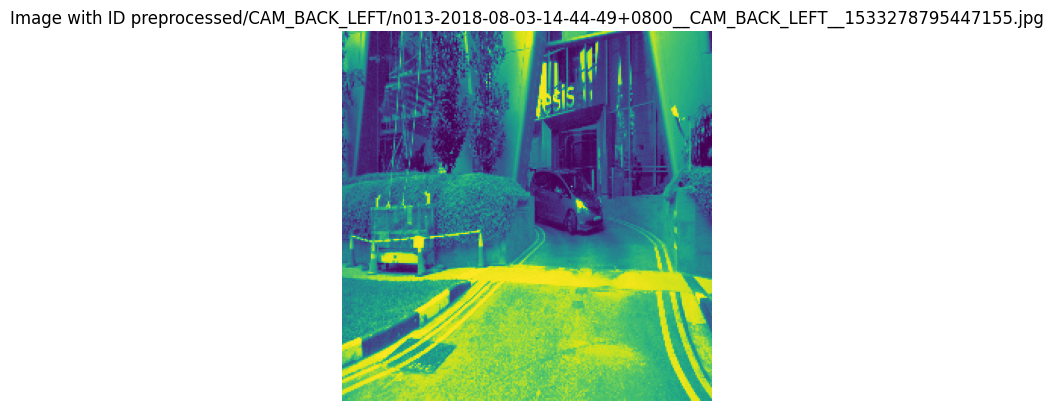

In [67]:
image = "preprocessed/CAM_BACK_LEFT/n013-2018-08-03-14-44-49+0800__CAM_BACK_LEFT__1533278795447155.jpg"
plot_image(image)

### Resize Images

In [14]:
# Function to downscale and re-upload the image to a new path
def downscale_and_reupload(image_blob_name):
    # Download the original image
    blob_client = container_client.get_blob_client(image_blob_name)
    blob_data = blob_client.download_blob().readall()

    # Open the image using Pillow
    image_data = io.BytesIO(blob_data)
    image = Image.open(image_data)

    # Downscale the image
    #new_width = image.width // downscale_factor
    #new_height = image.height // downscale_factor
    downscaled_image = image.resize((256, 256), Image.Resampling.LANCZOS)

    # Save the downscaled image to a file-like object
    output_stream = io.BytesIO()
    downscaled_image.save(output_stream, format='JPEG')
    output_stream.seek(0)  # Reset the stream position to the beginning

    # Create a new blob name with the desired path
    new_blob_name = image_blob_name.replace("samples", "resized_samples")

    # Re-upload the downscaled image to the new path
    new_blob_client = container_client.get_blob_client(new_blob_name)
    new_blob_client.upload_blob(output_stream, overwrite=True)  # Overwrite if it exists

    return new_blob_name  # Return the name of the re-uploaded image

blobs = container_client.list_blobs()
for blob in blobs:
    if blob.name.endswith(".jpg"):
        image_blob_name = blob.name
        downscaled_image_blob_name= downscale_and_reupload(image_blob_name)
        print(f"Downscaled image re-uploaded as: {downscaled_image_blob_name}")


Downscaled image re-uploaded as: resized_samples/CAM_BACK/n003-2018-01-03-12-03-23+0800__CAM_BACK__1514952316316487.jpg
Downscaled image re-uploaded as: resized_samples/CAM_BACK/n003-2018-01-08-11-30-34+0800__CAM_BACK__1515382745757583.jpg
Downscaled image re-uploaded as: resized_samples/CAM_BACK/n003-2018-07-12-15-40-35+0800__CAM_BACK__1531383596387543.jpg
Downscaled image re-uploaded as: resized_samples/CAM_BACK/n005-2018-06-14-20-11-03+0800__CAM_BACK__1528979868187591.jpg
Downscaled image re-uploaded as: resized_samples/CAM_BACK/n008-2018-06-04-16-30-00-0400__CAM_BACK__1528144232887570.jpg
Downscaled image re-uploaded as: resized_samples/CAM_BACK/n009-2018-05-08-15-52-41-0400__CAM_BACK__1525809758643363.jpg
Downscaled image re-uploaded as: resized_samples/CAM_BACK/n010-2018-08-27-12-00-23+0800__CAM_BACK__1535342963787283.jpg
Downscaled image re-uploaded as: resized_samples/CAM_BACK/n013-2018-08-20-14-38-24+0800__CAM_BACK__1534747168787005.jpg
Downscaled image re-uploaded as: resized

In [7]:
# Example image to process
image_blob_name = "samples/CAM_BACK_LEFT/n013-2018-08-03-14-44-49+0800__CAM_BACK_LEFT__1533278795447155.jpg"

# Downscale the image and re-upload to a new path
downscaled_image_blob_name = downscale_and_reupload(image_blob_name, 5)

print(f"Downscaled image re-uploaded as: {downscaled_image_blob_name}")

Downscaled image re-uploaded as: processed_samples/CAM_BACK_LEFT/n013-2018-08-03-14-44-49+0800__CAM_BACK_LEFT__1533278795447155.jpg


### Delete files in Azure

In [10]:
### delete files in azure
# Specify the folder prefix (e.g., "samples/")
#folder_prefixes = ["processed_samples/CAM_BACK/","processed_samples/CAM_BACK_LEFT/","processed_samples/CAM_BACK_RIGHT/",
#                 "processed_samples/CAM_FRONT/","processed_samples/CAM_FRONT_LEFT/","processed_samples/CAM_FRONT_RIGHT/"]


# List all blobs in the folder
blobs = container_client.list_blobs(name_starts_with="preprocessed")
blobs
# Delete each blob in the folder
for blob in blobs:
    blob_client = container_client.get_blob_client(blob.name)
    blob_client.delete_blob()
    print(f"Deleted blob: {blob.name}")

### Count Files in Azure Folder

In [ ]:
#check number ob blobs in folder

container_name = "datacomplete"  # Your Azure Blob Storage container
container_client = blob_service_client.get_container_client(container_name)


#folders=['CAM_BACK','CAM_BACK_LEFT','CAM_BACK_RIGHT','CAM_FRONT','CAM_FRONT_LEFT','CAM_FRONT_RIGHT']
# Specify the folder prefix (e.g., "samples/")
prefix = "preprocessed"
for folder in folders: 
    # List all blobs in the container
    #folder_prefix=f"{prefix}{folder}/"
    folder_prefix=f"{prefix}/"
    blobs = container_client.list_blobs(name_starts_with=folder_prefix)

    # Count the blobs that start with the specified folder prefix
    blob_count = sum(1 for _ in blobs)  # Generator comprehension to count blobs

    print(f"Number of blobs in '{folder_prefix}': {blob_count}")


Number of blobs in 'samples/CAM_BACK/': 17105
Number of blobs in 'samples/CAM_BACK_LEFT/': 14882
Number of blobs in 'samples/CAM_BACK_RIGHT/': 13341
Number of blobs in 'samples/CAM_FRONT/': 18368
Number of blobs in 'samples/CAM_FRONT_LEFT/': 15167
Number of blobs in 'samples/CAM_FRONT_RIGHT/': 14613


In [5]:
container_name = "datacomplete"  # Your Azure Blob Storage container
container_client = blob_service_client.get_container_client(container_name)

folder_prefix="preprocessed"
# List all blobs in the folder
blobs = container_client.list_blobs(name_starts_with=folder_prefix)

# Delete each blob in the folder
for blob in blobs:
    blob_client = container_client.get_blob_client(blob.name)
    blob_client.delete_blob()
    print(f"Deleted blob: {blob.name}")